In [1]:
import os
import sys
import numpy as np
import torch
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
sys.path.append("../0.mc_utils/")

In [3]:
from common.unity_visualizer import play_kp2ds_animation
from common.plot_dots import draw_traj2D,draw_traj3D
#%matplotlib
import pylab
pylab.rcParams["figure.figsize"]=(8,8)

In [4]:
raw_data0 = np.load("E:/20190727-area51/tripleSalchow_c0_20200115_002/op25b_x2ds.npz",allow_pickle=True)
op25b_x2ds0 = raw_data0["op25b"].item()

raw_data1 = np.load("E:/20190727-area51/tripleSalchow_c3_20200115_002/op25b_x2ds.npz",allow_pickle=True)
op25b_x2ds1 = raw_data1["op25b"].item()

max_frame_index = max(list(op25b_x2ds0.keys())[-1],list(op25b_x2ds1.keys())[-1])

In [9]:
max_frame_index

149

In [18]:
x2ds_list = []
for i in range(max_frame_index+1):
    if i in op25b_x2ds0 and i in op25b_x2ds1:
        x = np.concatenate([op25b_x2ds0[i][:1],op25b_x2ds1[i][:1]],axis=0)
        x2ds_list.append(x[...,:2])
mview_x2ds = np.array(x2ds_list)
print(mview_x2ds.shape)

(150, 2, 25, 2)


In [19]:
def build_projMatrix(K,R,t):
    assert K.shape==(3,3)
    assert R.shape==(3,3)
    assert len(t)==3 and t.ndim==1
    prjMat = np.zeros((3,4),dtype=np.float64)
    prjMat[:3,:3] = R
    prjMat[:3,-1] = t
    prjMat = np.matmul(K,prjMat)
    return prjMat

In [20]:
play_kp2ds_animation(mview_x2ds[:,1,...,:2],fps=30,framesize=(1920,1080))

In [21]:
# K = np.array([[1140.0,    0.0,framesize[0]/2],
#               [   0.0, 1140.0,framesize[1]/2],
#               [   0.0,    0.0,           1.0]])
K = np.array([[1787.44,    0.0,1920/2],
              [   0.0, 1786.79,1080/2],
              [   0.0,    0.0,    1.0]])
print("K:\n",K)

K:
 [[1.78744e+03 0.00000e+00 9.60000e+02]
 [0.00000e+00 1.78679e+03 5.40000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


In [37]:
#only trajectory x2d points are needed
#use head has the mutal feature points
joint_index = 12
traj_x0 = mview_x2ds[:,0,joint_index]
traj_x1 = mview_x2ds[:,1,joint_index] #10 is captured by OP, more reliable than 0.

In [38]:
######################################################
## step1.compute essential matrix based on x1 and x2
######################################################
E = cv2.findEssentialMat(traj_x0,traj_x1,K,cv2.RANSAC,prob=0.999,threshold=0.5)[0]
retval,R,t,mask = cv2.recoverPose(E,traj_x0,traj_x1,K)
t = t[:,0]
print(R)
print(t)

######################################################
## step2. Build projection matrix
######################################################
prjMat0 = build_projMatrix(K,np.eye(3),np.zeros(3,dtype=np.float64))
prjMat1 = build_projMatrix(K,R,t)
print(">>>Mat0:{}\n{}".format(prjMat0.shape,prjMat0))
print(">>>Mat1:{}\n{}".format(prjMat1.shape,prjMat1))

######################################################
## step3. TRIANGULATE!!!!
######################################################
ret = cv2.triangulatePoints(prjMat0,prjMat1,traj_x0.T,traj_x1.T).T
triangulated_trajs = ret/(ret[:,-1:]+1e-5)
triangulated_trajs = triangulated_trajs[:,:3]*20 # this 20 is just a scale, you can set it to 10 or other
print(triangulated_trajs[:5])

[[ 0.9243895  -0.06139056  0.37647743]
 [ 0.04626182  0.9977217   0.04910454]
 [-0.37863426 -0.02797519  0.9251235 ]]
[-0.98449732 -0.17509049  0.01040849]
>>>Mat0:(3, 4)
[[1.78744e+03 0.00000e+00 9.60000e+02 0.00000e+00]
 [0.00000e+00 1.78679e+03 5.40000e+02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]
>>>Mat1:(3, 4)
[[ 1.28880188e+03 -1.36588131e+02  1.56104938e+03 -1.74973775e+03]
 [-1.21802337e+02  1.76761255e+03  5.87306198e+02 -3.07229360e+02]
 [-3.78634257e-01 -2.79751930e-02  9.25123499e-01  1.04084907e-02]]
[[-10.02268937   0.53183966  37.54732377]
 [ -9.76598531   0.52536529  37.65365764]
 [ -9.43112629   0.48045674  37.66855494]
 [ -9.20500487   0.47533956  37.8274149 ]
 [ -8.87137108   0.44038554  37.85036487]]


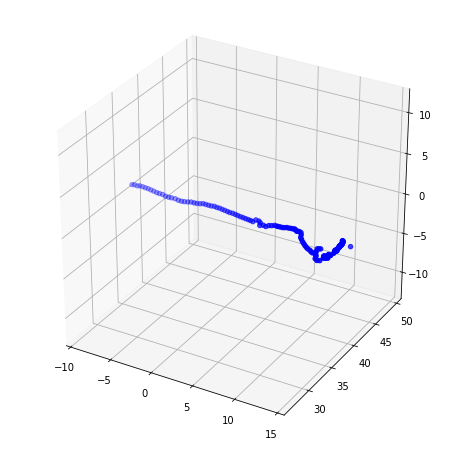

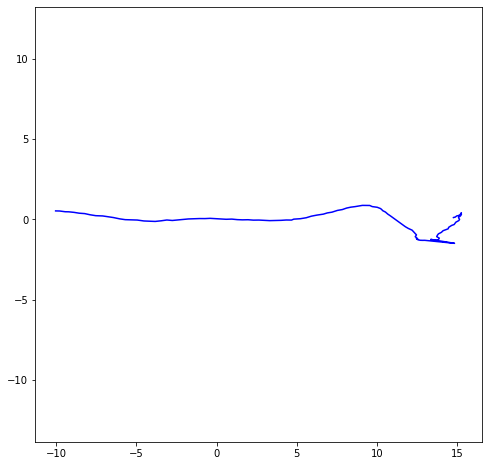

In [39]:
draw_traj3D(triangulated_trajs[:,0],triangulated_trajs[:,2],triangulated_trajs[:,1])
draw_traj2D(triangulated_trajs[:,0],triangulated_trajs[:,1])

In [41]:
np.save("E:/20190727-area51/tripleSalchow_c0_20200115_002_traj.npy",triangulated_trajs)

In [40]:
triangulated_trajs.shape

(150, 3)